In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Mabda 2020 Exam, by Edoardo Gallo

This exam is a **REGRESSION** problem. It asks you to predict the *SP500 monthly return rate* based on a set of indicators that can be: monthly stock prices indexes for the major world Economies (UK, EA, GER, IT, FR, JP, CA), financial market indicators (taken from Goyal and Welch) and macroeconomic indicators.

The *SP500 monthly return rate* are recorded in the dataset as **CRSP_SPvw**.

The financial market indicators from **Goyal and Welch** contains key variables related to the most important stock market features over time.

Extra information about the Goyal and Welch variables can be find at the following link: https://www.nber.org/system/files/working_papers/w10483/w10483.pdf

The *timeseries_train.csv* dataset contains all these variables from January 1970 to December 2009. All the variables have already been properly **stationarized**. The target variables (y) is the *SP500 monthly return rate (**CRSP_SPvw**)* while all the other variables are the predictors (X).

You need to use such predictors to train your algorithms in predicting the target variable.

The *timeseries_test.csv* dataset contains information **ONLY** about these variables from January 2010 to March 2020. You do not have information about the *SP500 monthly return rate (**CRSP_SPvw**)* (target or y).

Following the steps below, you are required to use the *timeseries_train.csv* dataset to train your algorithms, select the best one with its hyperparameters properly calibrated and then apply such model to the *timeseries_test.csv* in order to predict the *SP500 monthly return rate*

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import keras
import tensorflow
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## A. Import, Clean and Manipulate the Data

In [7]:
# importing data
data = pd.read_csv("timeseries_train.csv", sep = ";")
data

,dates,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,...,"France: Paris Stock Market: Price Index: CAC 40 (AVG, Dec-31-87=1000)","Germany: Stock Market Indexes: DAX Performance Index (AVG, Dec-30-87=1000)","Germany: Deutsche Boerse Market Capitalization (EOP, Mil.Euros)","Italy: Stock Price Index: FTSE MIB (AVG, Dec-31-97=24401.54)","Italy: Borsa Italiana Market Capitalization (EOP, Mil.EUR)","Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)","Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)","U.K.: London Stock Exchange: FTSE 100 (EOP, Jan-2-84=1000)","UK: London Stock Exchange Market Capitalization (EOP, Mil.EUR)",CRSP_SPvw
0,31/01/70,NaN,NaN,0.700347,NaN,NaN,NaN,NaN,0.034473,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.075398
1,28/02/70,0.1055,-0.8764,0.670148,0.0005,0.0002,-0.0008,-0.0042,0.035855,-0.000617,...,NaN,NaN,NaN,NaN,NaN,-0.052014,3.491356,NaN,NaN,0.059521
2,31/03/70,0.1051,-0.8842,0.690327,-0.0074,-0.0009,-0.0015,0.0010,0.035842,-0.000417,...,NaN,NaN,NaN,NaN,NaN,5.830915,4.877206,NaN,NaN,0.002806
3,30/04/70,0.1050,-0.6535,0.736751,-0.0050,-0.0001,0.0007,0.0038,0.035712,-0.000100,...,NaN,NaN,NaN,NaN,NaN,-0.186356,-14.638008,NaN,NaN,-0.088831
4,31/05/70,0.1052,-0.6576,0.774228,-0.0012,0.0028,0.0028,0.0044,0.038661,0.000275,...,NaN,NaN,NaN,NaN,NaN,-17.819392,-1.173458,NaN,NaN,-0.054689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,31/08/09,-2.2805,16.7640,0.237594,0.0000,-0.0015,-0.0051,-0.0015,-0.008173,-0.000008,...,9.720526,8.620088,-0.412412,11.448841,6.690895,7.350982,1.740772,6.316916,4.972421,0.034751
476,30/09/09,-2.3337,14.3530,0.232310,-0.0001,-0.0013,-0.0027,-0.0012,-0.000063,-0.000042,...,5.304972,3.439032,3.729266,5.691791,4.732059,-1.229733,-5.469457,4.481572,1.638849,0.036534
477,31/10/09,-2.1085,70.3855,0.232299,-0.0005,0.0002,-0.0002,0.0017,0.003146,-0.000042,...,1.258146,1.705828,-4.673914,2.451208,-4.411161,-2.323525,-1.204183,-1.754724,-1.057252,-0.018259
478,30/11/09,-2.1539,40.9009,0.218105,-0.0005,0.0004,0.0003,-0.0014,0.007464,-0.000017,...,-0.724043,-0.669130,2.764711,-3.207440,-2.112982,-4.316345,-6.312860,2.855020,0.632146,0.060257


### Dropping columns

In [8]:
# selecting the columns with less than 10 years observations(more than 120 Nans)
columns_to_drop = data.loc[:, np.sum(data.isnull()) > 120].columns
columns_to_drop

Index(['ACOGNO', 'Canada: TSX Group Market Capitalization (EOP, Mil.C$)',
       'EU 27: MSCI Share Price Index ex Div, LocCur (NSA, EOP, Dec-87=100)',
       'France: Paris Stock Market: Price Index: CAC 40 (AVG, Dec-31-87=1000)',
       'Germany: Stock Market Indexes: DAX Performance Index (AVG, Dec-30-87=1000)',
       'Germany: Deutsche Boerse Market Capitalization (EOP, Mil.Euros)',
       'Italy: Stock Price Index: FTSE MIB (AVG, Dec-31-97=24401.54)',
       'Italy: Borsa Italiana Market Capitalization (EOP, Mil.EUR)',
       'U.K.: London Stock Exchange: FTSE 100 (EOP, Jan-2-84=1000)',
       'UK: London Stock Exchange Market Capitalization (EOP, Mil.EUR)'],
      dtype='object')

In [9]:
#dropping the columns
print("dimension before dropping: {}".format(data.shape))
data = data.drop(columns_to_drop, axis = 1)
print("dimension after dropping: {}".format(data.shape))


dimension before dropping: (480, 163)
dimension after dropping: (480, 153)


In [10]:
# I drop this column too, since in the test set has all nan values
data.drop('csp', axis = 1, inplace = True)

In [11]:
print("dimension after dropping: {}".format(data.shape))

dimension after dropping: (480, 152)


### Replace Nan values

In [12]:
# showing all the columns with at least 1 Nan value
data.loc[:, np.sum(data.isnull()) >= 1]

,D12,E12,tbl,AAA,BAA,lty,Rfree,D/Y,E/P 10y,TWEXAFEGSMTHx,UMCSENTx,"Canada: S&P/TSX Composite Index, Close Price (AVG, 1975=1000)","Canada: MSCI Share Price Index ex Div, US$ (NSA, EOP, Dec-69=100)","Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)","Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1055,-0.8764,0.0005,0.0002,-0.0008,-0.0042,-0.000617,-0.987621,NaN,NaN,NaN,NaN,4.102746,-0.052014,3.491356
2,0.1051,-0.8842,-0.0074,-0.0009,-0.0015,0.0010,-0.000417,-1.037922,NaN,NaN,NaN,NaN,0.775571,5.830915,4.877206
3,0.1050,-0.6535,-0.0050,-0.0001,0.0007,0.0038,-0.000100,-1.038323,NaN,NaN,NaN,NaN,-12.404421,-0.186356,-14.638008
4,0.1052,-0.6576,-0.0012,0.0028,0.0028,0.0044,0.000275,-0.942430,NaN,NaN,NaN,NaN,-10.282468,-17.819392,-1.173458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-2.2805,16.7640,0.0000,-0.0015,-0.0051,-0.0015,-0.000008,-1.395314,-0.996895,-1.601524,-0.3,4.961329,-1.608526,7.350982,1.740772
476,-2.3337,14.3530,-0.0001,-0.0013,-0.0027,-0.0012,-0.000042,-1.451660,-1.005237,-1.584639,7.8,3.975804,6.785695,-1.229733,-5.469457
477,-2.1085,70.3855,-0.0005,0.0002,-0.0002,0.0017,-0.000042,-1.507845,-1.008023,-1.658745,-2.9,0.323243,-5.462480,-2.323525,-1.204183
478,-2.1539,40.9009,-0.0005,0.0004,0.0003,-0.0014,-0.000017,-1.509424,-1.007648,-0.602732,-3.2,1.061609,6.971495,-4.316345,-6.312860


In [13]:
# looking at the variance to choose which replacement to make
data.describe()

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,ltr,...,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,"Canada: S&P/TSX Composite Index, Close Price (AVG, 1975=1000)","Canada: MSCI Share Price Index ex Div, US$ (NSA, EOP, Dec-69=100)","Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)","Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)",CRSP_SPvw
count,479.000000,479.000000,480.000000,479.000000,479.000000,479.000000,479.000000,480.000000,479.000000,480.000000,...,480.000000,480.000000,480.000000,480.000000,480.000000,395.000000,479.000000,479.000000,479.000000,480.000000
mean,0.408698,0.456268,0.522211,-0.000162,-0.000055,-0.000052,-0.000049,0.011185,-0.000014,0.007382,...,-0.001141,-0.001588,-0.004171,0.001352,20.558079,0.620671,0.570901,0.307894,0.607270,0.008978
std,0.585932,6.001773,0.296665,0.005071,0.002542,0.002445,0.003381,0.020329,0.000423,0.031201,...,0.639619,2.410095,1.274555,1.124985,7.468124,4.077185,5.883142,4.730368,5.250364,0.045127
min,-2.333700,-52.828000,0.120510,-0.046200,-0.011800,-0.010200,-0.016400,-0.057654,-0.003850,-0.112400,...,-3.449091,-14.429009,-7.647989,-8.089393,10.484200,-24.201664,-31.683606,-28.500410,-22.129527,-0.215795
25%,0.108300,-0.678400,0.274474,-0.001550,-0.001200,-0.001300,-0.001800,0.001205,-0.000129,-0.010500,...,-0.238611,-0.929368,-0.535347,-0.593550,15.661175,-1.403755,-2.376727,-1.843206,-2.335465,-0.015899
50%,0.479500,0.738700,0.440460,0.000000,-0.000100,-0.000100,-0.000100,0.013372,0.000000,0.007800,...,0.001171,0.038803,0.083713,0.057688,18.926000,0.768887,0.942354,0.629102,0.880259,0.011994
75%,0.792300,1.802500,0.748185,0.001600,0.001100,0.001100,0.001700,0.026438,0.000133,0.024325,...,0.239743,0.956693,0.545772,0.637575,23.545775,3.241493,4.092420,3.135632,3.826297,0.038461
max,1.716900,70.385500,1.206530,0.026100,0.012900,0.015700,0.011400,0.045747,0.002175,0.152300,...,5.959410,13.810457,8.497566,4.962298,67.151000,10.973745,19.069660,14.219130,16.898864,0.168113


#### Since the features seems to not have that much variance to choose the **median** as replacement, I will go with the **mean**

In [14]:
data.fillna(data.mean(), inplace = True)

# checking if the filling worked out
data.isnull().any().sum()

<ipython-input-14-0c5a4d7ca179>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace = True)


0

### Dividing **continous** and **categorical**



In [15]:
d_cont = data.select_dtypes(include = 'float64')
d_cat = data.select_dtypes(exclude = 'float64')



In [16]:
d_cat.head()

,dates,HWI
0,31/01/70,-153
1,28/02/70,-36
2,31/03/70,-184
3,30/04/70,-91
4,31/05/70,-194


#### Since **HWI** is a continous variable too, I convert it and transform **d_cont** in **X** since every column will be used as predictor.

In [17]:
data['HWI'] = data['HWI'].astype(float)

x = data.select_dtypes(include = 'float64')


### Take dates for plotting

In [18]:
#useful for plot
data['dates'] = pd.to_datetime(data['dates'])

### Dropping target variable

In [19]:
# dropping target variable
y = data['CRSP_SPvw']
x.drop('CRSP_SPvw', axis = 1, inplace = True)

### Scale data

In [20]:
sc = StandardScaler()

x_scaled = sc.fit_transform(x)

### Looking at **Correlation** between new dataset and target variable

In [21]:
# create the dataframe of the scaled values
df_x_scaled = pd.DataFrame(x_scaled, columns = x.columns)

# add y
data_scaled = pd.concat([df_x_scaled, y], axis = 1)

# correlation
cor = data_scaled.corr()

#sorting values
cor.sort_values('CRSP_SPvw', inplace = True, ascending = False)

#top 10 positive
cor['CRSP_SPvw'][1:10]

Canada: MSCI Share Price Index ex Div, US$ (NSA, EOP, Dec-69=100)        0.745427
S&P 500                                                                  0.659790
S&P: indust                                                              0.653270
S&P PE ratio                                                             0.535205
Canada: S&P/TSX Composite Index, Close Price (AVG, 1975=1000)            0.463284
Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)    0.400496
corpr                                                                    0.315496
Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)         0.277427
ltr                                                                      0.212480
Name: CRSP_SPvw, dtype: float64

In [22]:
# top 10 negative
cor.sort_values('CRSP_SPvw', inplace = True, ascending = True)
cor['CRSP_SPvw'][0:10]

S&P div yield   -0.609288
svar            -0.317676
BAA.1           -0.263663
BAA             -0.260437
AAA.1           -0.235382
AAA             -0.232521
lty             -0.225801
GS10            -0.200896
EXCAUSx         -0.197226
GS5             -0.191929
Name: CRSP_SPvw, dtype: float64

#### It's not a surprise to see as the most correlated all the features related to **S&P 500**. What is surprising is that the **Canada stock market index** is more correlated than those.

## B: Models

#### I will use **TimeSeriesSplit** to divide in train and test set inside **GridSearchCV**,so I thought that I should not need to make train and test set.

#### Since it is asked to plot the predicted value and confront it with the real value, I cannot call **predict()** on the same set that i used to train the gridsearch algorithm.

#### So i will create **train/test** set with size of the test of $15\%$


In [23]:
x_scaled_train = x_scaled[:408]
y_train = y[:408]

x_scaled_test = x_scaled[408:]
y_test = y[408:]

### Gridsearch with Ridge

In [24]:
alphas = np.logspace(-2, -.5, 20)
params = [{'alpha': alphas}]

tss = TimeSeriesSplit()

ridge = Ridge(random_state=90, max_iter=1000)

grid_rid = GridSearchCV(ridge, params, cv=tss, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'], refit = 'neg_mean_squared_error', n_jobs = -1)

grid_rid.fit(x_scaled_train, y_train)




GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(max_iter=1000, random_state=90), n_jobs=-1,
             param_grid=[{'alpha': array([0.01      , 0.01199354, 0.0143845 , 0.01725211, 0.02069138,
       0.02481629, 0.02976351, 0.03569699, 0.04281332, 0.05134833,
       0.06158482, 0.073862  , 0.08858668, 0.10624678, 0.1274275 ,
       0.15283067, 0.18329807, 0.21983926, 0.26366509, 0.31622777])}],
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

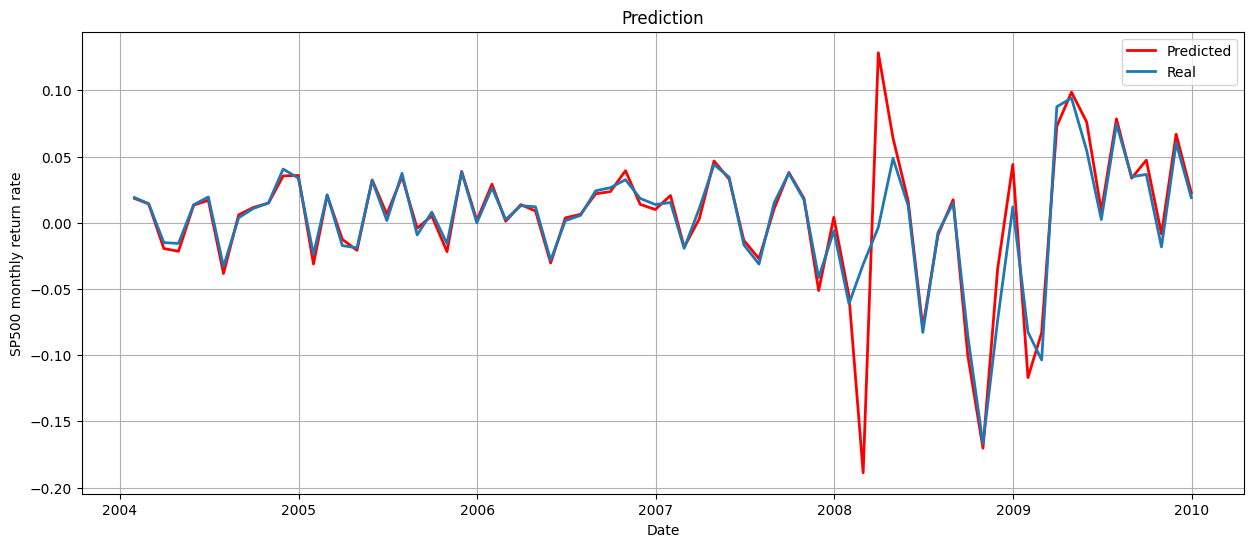

In [25]:
y_pred = grid_rid.predict(x_scaled_test)



plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data.iloc[408:,0], y_pred, color = 'red', lw = 2)
line_true, = plt.plot(data.iloc[408:,0], y_test, lw = 2)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])

#### This model seems to catch quite good(probably too much) the real value except for 2008.

#### Let's look at the **MSE** and **MAE**

Text(0.5, 1.0, 'MAE')

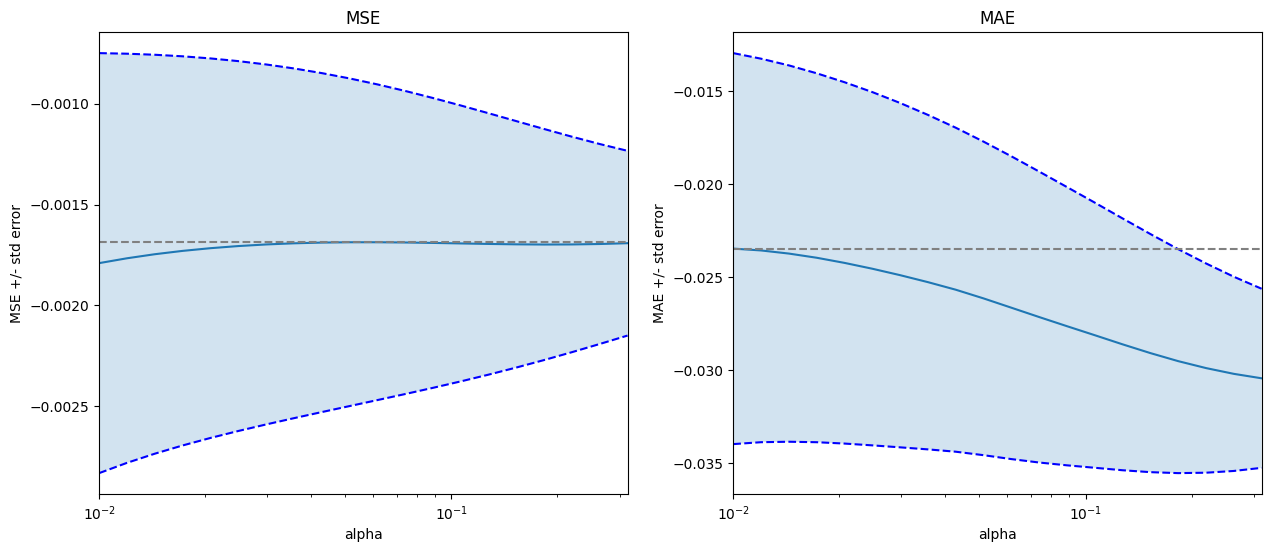

In [26]:
MSE_rid = grid_rid.cv_results_['mean_test_neg_mean_squared_error']
MSE_std_rid = grid_rid.cv_results_['std_test_neg_mean_squared_error']

MAE_rid = grid_rid.cv_results_['mean_test_neg_mean_absolute_error']
MAE_std_rid = grid_rid.cv_results_['std_test_neg_mean_absolute_error']

plt.figure().set_size_inches(15, 6)

ax = plt.subplot(1,2,1)
plt.semilogx(alphas, MSE_rid)
std_error = MSE_std_rid/ np.sqrt(5) # 5 because TimeSeriesSplit has as default value n_folds = 5

plt.semilogx(alphas, MSE_rid + std_error, 'b--')
plt.semilogx(alphas, MSE_rid - std_error, 'b--')

plt.fill_between(alphas, MSE_rid + std_error, MSE_rid - std_error, alpha=0.2)

plt.ylabel('MSE +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(MSE_rid), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.title("MSE")


ax = plt.subplot(1,2,2)
plt.semilogx(alphas, MAE_rid)
std_error = MAE_std_rid/ np.sqrt(5)

plt.semilogx(alphas, MAE_rid + std_error, 'b--')
plt.semilogx(alphas, MAE_rid - std_error, 'b--')

plt.fill_between(alphas, MAE_rid + std_error, MAE_rid - std_error, alpha=0.2)

plt.ylabel('MAE +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(MAE_rid), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.title("MAE")



In [27]:
print(grid_rid.cv_results_['rank_test_neg_mean_squared_error'][0])
print(grid_rid.cv_results_['rank_test_neg_mean_absolute_error'][0])

20
1


In [28]:
# 19 and 0 comes from the rank returned by 'grid_rid.cv_results_'
print("Best parameter alpha:%s, MSE=%s, MAE=%s" % (grid_rid.best_params_['alpha'], -MSE_rid[19], -MAE_rid[0] ))

Best parameter alpha:0.06158482110660264, MSE=0.0016915929380615757, MAE=0.02347002293105658


### Let now see how the Gridsearch with **Lasso** perform:

In [29]:
alphas = np.logspace(-5, -3.5, 20)
params = [{'alpha': alphas}]

lasso = Lasso(random_state=90, max_iter=1000)
grid_las = GridSearchCV(lasso, params, cv=tss,scoring = ['neg_mean_squared_error','neg_mean_absolute_error'], refit= 'neg_mean_squared_error', n_jobs = -1)
grid_las.fit(x_scaled_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-02, tolerance: 8.429e-05
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Lasso(random_state=90), n_jobs=-1,
             param_grid=[{'alpha': array([1.00000000e-05, 1.19935395e-05, 1.43844989e-05, 1.72521055e-05,
       2.06913808e-05, 2.48162892e-05, 2.97635144e-05, 3.56969885e-05,
       4.28133240e-05, 5.13483291e-05, 6.15848211e-05, 7.38619982e-05,
       8.85866790e-05, 1.06246783e-04, 1.27427499e-04, 1.52830673e-04,
       1.83298071e-04, 2.19839265e-04, 2.63665090e-04, 3.16227766e-04])}],
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

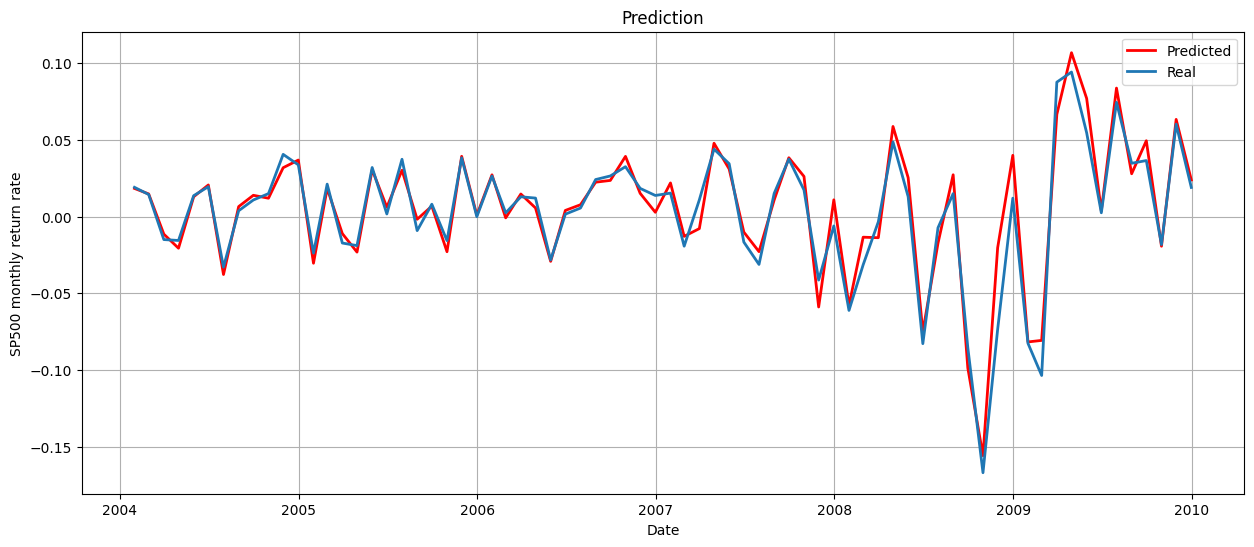

In [30]:
y_pred = grid_las.predict(x_scaled_test)



plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data.iloc[408:,0], y_pred, color = 'red', lw = 2)
line_true, = plt.plot(data.iloc[408:,0], y_test, lw = 2)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])

#### Lasso seems to go better than Ridge, and that is predictable since Lasso works better with **deep dataset** where it can select the **best features**, however there is a high probability that we are **overfitting**.

Text(0.5, 1.0, 'MAE')

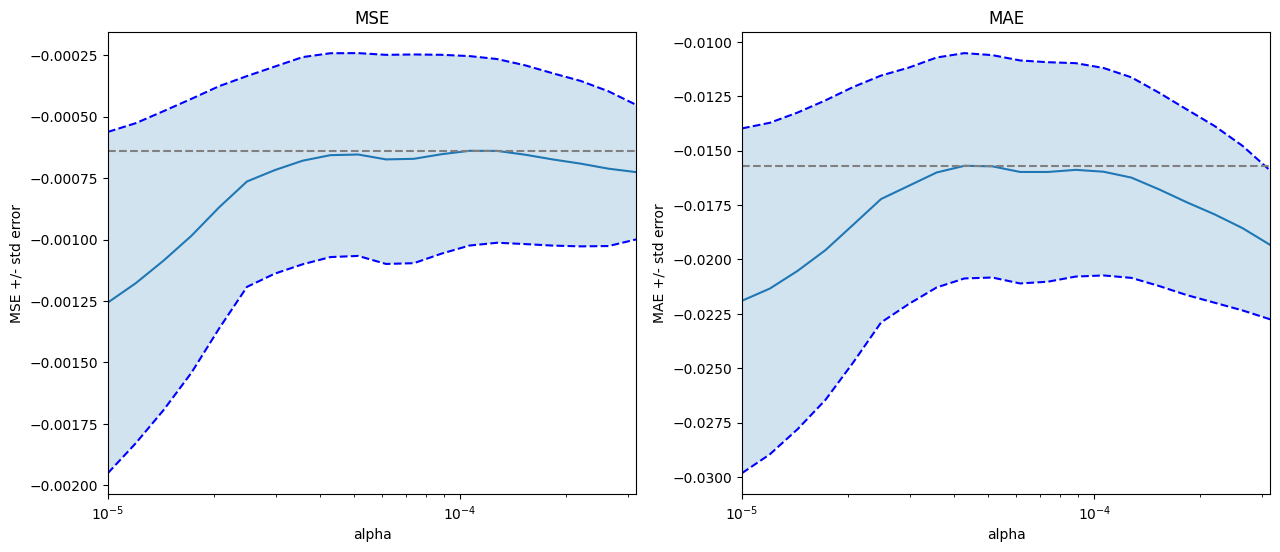

In [31]:
MSE_las = grid_las.cv_results_['mean_test_neg_mean_squared_error']
MSE_std_las = grid_las.cv_results_['std_test_neg_mean_squared_error']

MAE_las = grid_las.cv_results_['mean_test_neg_mean_absolute_error']
MAE_std_las = grid_las.cv_results_['std_test_neg_mean_absolute_error']

plt.figure().set_size_inches(15, 6)

ax = plt.subplot(1,2,1)
plt.semilogx(alphas, MSE_las)
std_error = MSE_std_las/ np.sqrt(5) # 5 because TimeSeriesSplit has as default value n_folds = 5

plt.semilogx(alphas, MSE_las + std_error, 'b--')
plt.semilogx(alphas, MSE_las - std_error, 'b--')

plt.fill_between(alphas, MSE_las + std_error, MSE_las - std_error, alpha=0.2)

plt.ylabel('MSE +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(MSE_las), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.title("MSE")


ax = plt.subplot(1,2,2)
plt.semilogx(alphas, MAE_las)
std_error = MAE_std_las/ np.sqrt(5)

plt.semilogx(alphas, MAE_las + std_error, 'b--')
plt.semilogx(alphas, MAE_las - std_error, 'b--')

plt.fill_between(alphas, MAE_las + std_error, MAE_las - std_error, alpha=0.2)

plt.ylabel('MAE +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(MAE_las), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.title("MAE")

In [32]:
print(grid_las.cv_results_['rank_test_neg_mean_squared_error'][0])
print(grid_las.cv_results_['rank_test_neg_mean_absolute_error'][0])

20
20


In [33]:
# 19 and 19 comes from the rank returned by 'grid_rid.cv_results_'
print("Best parameter alpha:%s, MSE=%s, MAE=%s" % (grid_las.best_params_['alpha'], -MSE_las[19], -MAE_las[19] ))

Best parameter alpha:0.0001062467830894041, MSE=0.0007258178285414385, MAE=0.019338014130423232


### Gridsearch with ElasticNet
#### Let's see if a combination of Lasso and Ridge could return better results


In [34]:

elastic = ElasticNet(random_state= 90)
params = {'alpha':np.logspace(-2,4,40),'l1_ratio':[.2,.4,.6,.8]}
grid_enet = GridSearchCV(estimator=elastic,
                    param_grid = params,
                    scoring=['neg_mean_squared_error','neg_mean_absolute_error'],
                    refit = 'neg_mean_squared_error',
                    cv = tss,
                    n_jobs = -1)
grid_enet.fit(x_scaled_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ElasticNet(random_state=90), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.42510267e-02, 2.03091762e-02, 2.89426612e-02,
       4.12462638e-02, 5.87801607e-02, 8.37677640e-02, 1.19377664e-01,
       1.70125428e-01, 2.42446202e-01, 3.45510729e-01, 4.92388263e-01,
       7.01703829...
       4.92388263e+01, 7.01703829e+01, 1.00000000e+02, 1.42510267e+02,
       2.03091762e+02, 2.89426612e+02, 4.12462638e+02, 5.87801607e+02,
       8.37677640e+02, 1.19377664e+03, 1.70125428e+03, 2.42446202e+03,
       3.45510729e+03, 4.92388263e+03, 7.01703829e+03, 1.00000000e+04]),
                         'l1_ratio': [0.2, 0.4, 0.6, 0.8]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

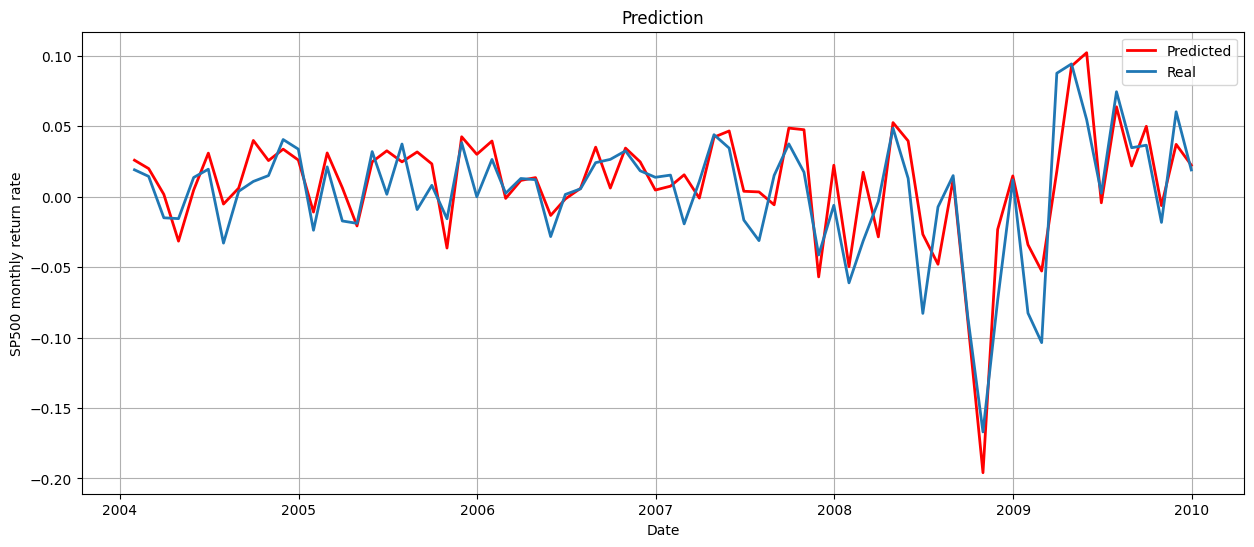

In [35]:
y_pred = grid_enet.predict(x_scaled_test)



plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data.iloc[408:,0], y_pred, color = 'red', lw = 2)
line_true, = plt.plot(data.iloc[408:,0], y_test, lw = 2)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])

#### Even though ElasticNet doesn't follow exactly as Lasso and Ridge, I think we could obtain better results on the test set since it almost catches all the fluctuations

In [36]:
print(grid_enet.cv_results_['rank_test_neg_mean_squared_error'][0])
print(grid_enet.cv_results_['rank_test_neg_mean_absolute_error'][0])

4
4


In [37]:
MSE_enet = grid_enet.cv_results_['mean_test_neg_mean_squared_error']
MAE_enet = grid_enet.cv_results_['mean_test_neg_mean_absolute_error']

# 3 and 3 comes from the 1°st of the rank returned by 'grid_enet.cv_results_'
print("Best parameter:{}, MSE={:.5f}, MAE={:.5f}".format(grid_enet.best_params_, -MSE_enet[3], -MAE_enet[3]))

Best parameter:{'alpha': 0.014251026703029978, 'l1_ratio': 0.2}, MSE=0.00090, MAE=0.02322


#### Until now as expected ElasticNet is the better one(looking at MSE)

### Polynomial features

#### I will try polynomial features to see if I can get better result, I think that the combination of the features could produce a better result

In [38]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(x_scaled)

In [39]:
x_scaled_train = X_poly[:408]


x_scaled_test = X_poly[408:]

In [40]:
params = {'alpha':np.logspace(-2,4,40),'l1_ratio':[.2,.4,.6,.8]}

grid_poly = GridSearchCV(elastic, params, cv = tss,scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'], refit = 'neg_mean_squared_error', n_jobs = -1)
grid_poly.fit(x_scaled_train, y_train)



GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ElasticNet(random_state=90), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.42510267e-02, 2.03091762e-02, 2.89426612e-02,
       4.12462638e-02, 5.87801607e-02, 8.37677640e-02, 1.19377664e-01,
       1.70125428e-01, 2.42446202e-01, 3.45510729e-01, 4.92388263e-01,
       7.01703829...
       4.92388263e+01, 7.01703829e+01, 1.00000000e+02, 1.42510267e+02,
       2.03091762e+02, 2.89426612e+02, 4.12462638e+02, 5.87801607e+02,
       8.37677640e+02, 1.19377664e+03, 1.70125428e+03, 2.42446202e+03,
       3.45510729e+03, 4.92388263e+03, 7.01703829e+03, 1.00000000e+04]),
                         'l1_ratio': [0.2, 0.4, 0.6, 0.8]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

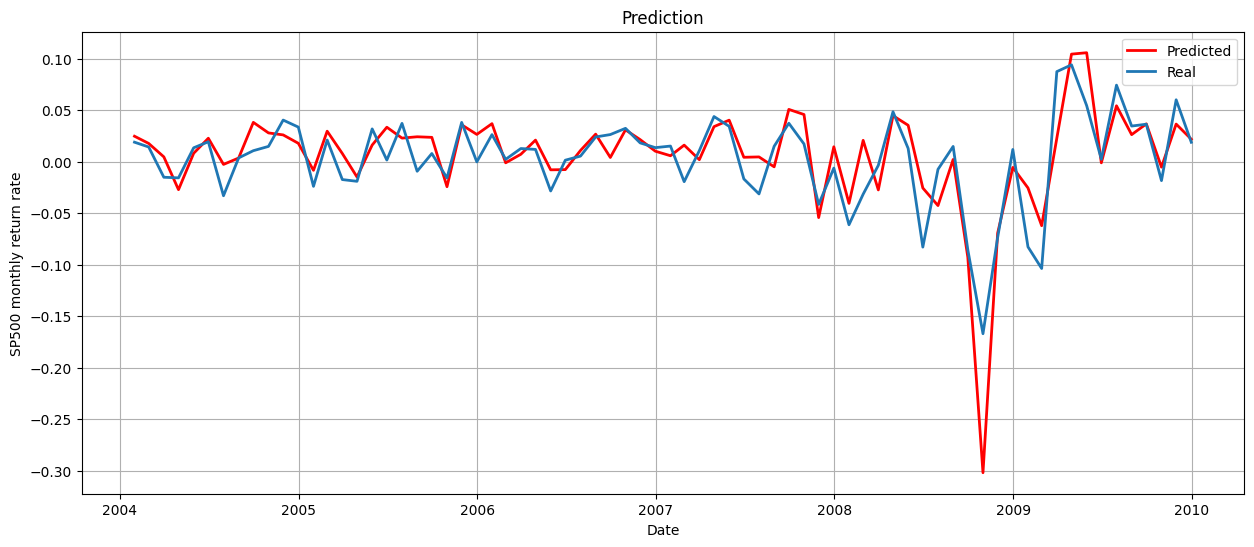

In [41]:
y_pred = grid_poly.predict(x_scaled_test)



plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data.iloc[408:,0], y_pred, color = 'red', lw = 2)
line_true, = plt.plot(data.iloc[408:,0], y_test, lw = 2)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])

In [42]:
print(grid_poly.cv_results_['rank_test_neg_mean_squared_error'][0])
print(grid_poly.cv_results_['rank_test_neg_mean_absolute_error'][0])

15
9


In [43]:
MSE_poly = grid_poly.cv_results_['mean_test_neg_mean_squared_error']
MAE_poly = grid_poly.cv_results_['mean_test_neg_mean_absolute_error']


print("Best parameter:{}, MSE={:.5f}, MAE={:.5f}".format(grid_poly.best_params_, -MSE_poly[14], -MAE_poly[8]))

Best parameter:{'alpha': 0.01, 'l1_ratio': 0.4}, MSE=0.00155, MAE=0.02624


#### The result is worse than I expected

### Now I will look at the model that almost always goes better than every other.**Random forest**

#### I start with a simple Decision Tree

In [44]:
# re-set train/test modified for polynomial
x_scaled_train = x_scaled[:408]
y_train = y[:408]

x_scaled_test = x_scaled[408:]
y_test = y[408:]

In [45]:
dt = DecisionTreeRegressor()
parameters = {'max_depth': range(1,19)}

grid_dt = GridSearchCV(dt, parameters, cv = tss, scoring =["neg_mean_squared_error","neg_mean_absolute_error"],refit ="neg_mean_squared_error" )
grid_dt.fit(x_scaled_train,y_train)



GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 19)},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

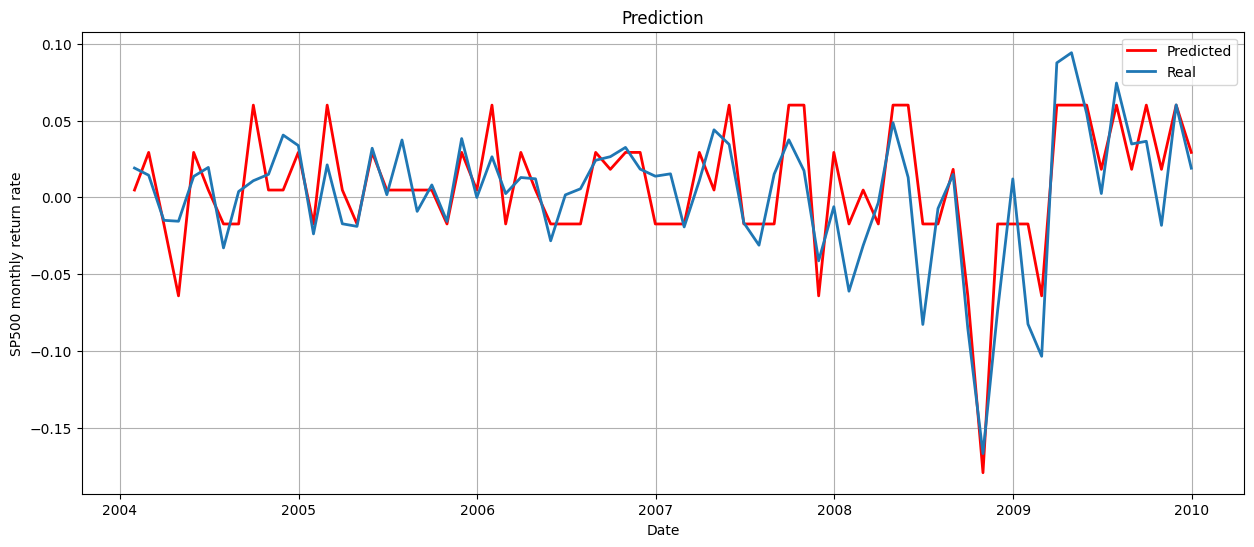

In [46]:
y_pred = grid_dt.predict(x_scaled_test)



plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data.iloc[408:,0], y_pred, color = 'red', lw = 2)
line_true, = plt.plot(data.iloc[408:,0], y_test, lw = 2)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])

In [47]:
print(grid_dt.cv_results_['rank_test_neg_mean_squared_error'][0])
print(grid_dt.cv_results_['rank_test_neg_mean_absolute_error'][0])

3
3


In [48]:
MSE_dt = grid_dt.cv_results_['mean_test_neg_mean_squared_error']
MAE_dt = grid_dt.cv_results_['mean_test_neg_mean_absolute_error']


print("Best parameter:{}, MSE={:.5f}, MAE={:.5f}".format(grid_dt.best_params_, -MSE_dt[2], -MAE_dt[2]))

Best parameter:{'max_depth': 3}, MSE=0.00127, MAE=0.02730


### Random Forest

In [49]:
rf = RandomForestRegressor(n_estimators = 300, oob_score = True)
params = {'max_depth': [6,8], 'min_samples_split': [12,15,18], 'min_samples_leaf': [2,3,6]}

grid_rf = GridSearchCV(rf, param_grid = params, cv = tss, scoring = ['neg_mean_squared_error','neg_mean_absolute_error' ], refit = 'neg_mean_squared_error',n_jobs = -1)

grid_rf.fit(x_scaled_train,y_train)



GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(n_estimators=300, oob_score=True),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8], 'min_samples_leaf': [2, 3, 6],
                         'min_samples_split': [12, 15, 18]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

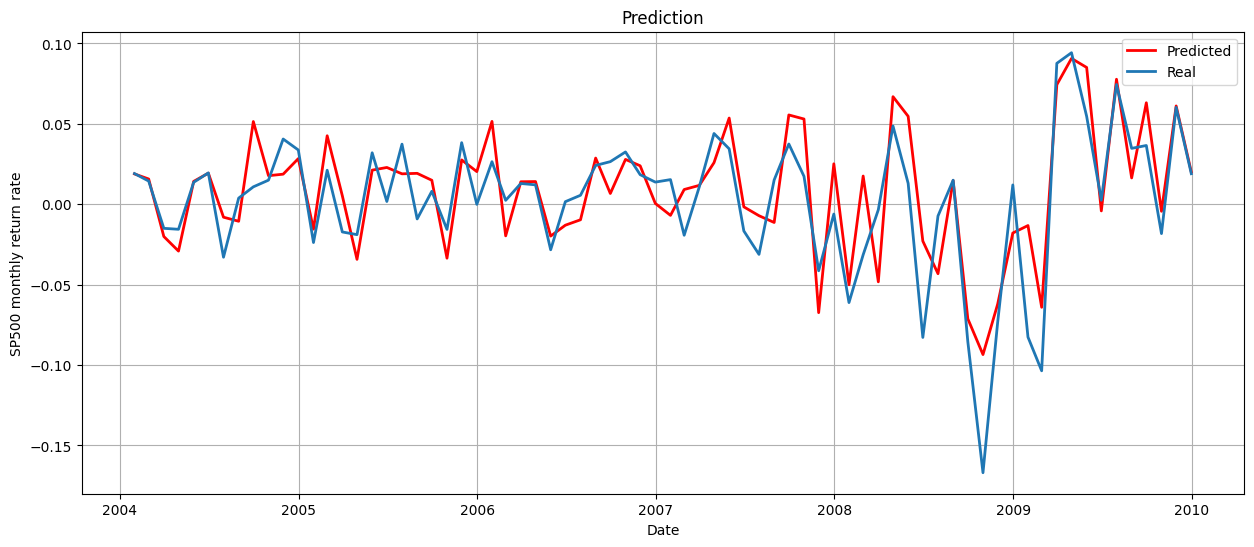

In [50]:
y_pred = grid_rf.predict(x_scaled_test)



plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data.iloc[408:,0], y_pred, color = 'red', lw = 2)
line_true, = plt.plot(data.iloc[408:,0], y_test, lw = 2)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])

In [51]:
print(grid_rf.cv_results_['rank_test_neg_mean_squared_error'][0])
print(grid_rf.cv_results_['rank_test_neg_mean_absolute_error'][0])

6
2


In [52]:
MSE_rf = grid_rf.cv_results_['mean_test_neg_mean_squared_error']
MAE_rf = grid_rf.cv_results_['mean_test_neg_mean_absolute_error']


print("Best parameter:{}, MSE={:.5f}, MAE={:.5f}".format(grid_rf.best_params_, -MSE_rf[7], -MAE_rf[7]))

Best parameter:{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 15}, MSE=0.00091, MAE=0.02261


### Neural Networks

#### I will try NN although I know that often is not necessary since random forest works very good

In [53]:
# initializing the NN
regressor = Sequential()

# first layer (input)
regressor.add(Dense(units = 76, activation = 'relu', input_dim = 150))

# dropout(to avoid overfitting)
regressor.add(Dropout(.2))

# second hidden layer
regressor.add(Dense(units = 76,  activation = 'relu'))

# dropout(to avoid overfitting)
regressor.add(Dropout(.2))

# Adding the output layer
regressor.add(Dense(units = 1, activation = 'linear'))

regressor.summary()

regressor.compile(optimizer = Adam(), loss = 'mean_squared_error', metrics = ['mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 76)                11476     
                                                                 
 dropout (Dropout)           (None, 76)                0         
                                                                 
 dense_1 (Dense)             (None, 76)                5852      
                                                                 
 dropout_1 (Dropout)         (None, 76)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 77        
                                                                 
Total params: 17405 (67.99 KB)
Trainable params: 17405 (67.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
batch_size = 30
epochs = 100
history = regressor.fit(x_scaled_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1)

score = regressor.evaluate(x_scaled_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
14/14 [==============================] - 1s 3ms/step - loss: 0.4317 - mae: 0.5051
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2607 - mae: 0.3807
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2150 - mae: 0.3423
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1464 - mae: 0.3004
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1204 - mae: 0.2682
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0904 - mae: 0.2301
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0856 - mae: 0.2260
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0663 - mae: 0.1967
Epoch 9/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0711 - mae: 0.2038
Epoch 10/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0489 - mae: 0.1740
Epoch 11/100
14/14 [==============================] - 0s 3m

In [55]:
print("MSE={:.5f}, MAE={:.5f}".format(-score[0], -score[1]))

MSE=-0.00246, MAE=-0.03407


# C) Best model selection

In [57]:
data_all = pd.read_csv("timeseries_all.csv", sep = ";")

data_test = pd.read_csv("timeseries_test.csv", sep = ";")

In [58]:
data_test['csp']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
118   NaN
119   NaN
120   NaN
121   NaN
122   NaN
Name: csp, Length: 123, dtype: float64

In [59]:
# dropping the same columns as the train set
data_test = data_test.drop(columns_to_drop, axis = 1)

In [60]:
# dropping also the target variable and this'csp' that has all NaNs
data_test = data_test.drop(["Unnamed: 162", "csp"], axis = 1)

In [61]:
# filling with the mean
data_test.fillna(data_test.mean(), inplace = True)

<ipython-input-61-fbb342b2f110>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_test.fillna(data_test.mean(), inplace = True)


In [62]:
data_test.isna().any().sum()

0

In [63]:
data_test['HWI'] = data_test['HWI'].astype(float)

x_TEST = data_test.select_dtypes(include = 'float64')

# scaling
x_TEST_scaled = sc.fit_transform(x_TEST)

# transforming for polynomial
x_TEST_poly = poly.fit_transform(x_TEST_scaled)

# selecting the target variable to compare
y_TEST = data_all.iloc[480:603, -1]

## Next I will predict to evaluate the MSE

In [64]:
# gridsearch with ridge
y_pred_gr = grid_rid.predict(x_TEST_scaled)
mse_gr = mean_squared_error(y_TEST, y_pred_gr)

# gridsearch with lasso
y_pred_gl = grid_las.predict(x_TEST_scaled)
mse_gl = mean_squared_error(y_TEST, y_pred_gl)

# gridsearch with elasticnet
y_pred_ge = grid_enet.predict(x_TEST_scaled)
mse_ge = mean_squared_error(y_TEST, y_pred_ge)

#gridsearch with elasticnet using polynomial features
y_pred_gp = grid_poly.predict(x_TEST_poly)
mse_gp = mean_squared_error(y_TEST, y_pred_gp)

#gridserch with decision tree
y_pred_gd = grid_dt.predict(x_TEST_scaled)
mse_gd = mean_squared_error(y_TEST, y_pred_gd)

# gridsearch with randomforest
y_pred_grf = grid_rf.predict(x_TEST_scaled)
mse_grf = mean_squared_error(y_TEST, y_pred_grf)

# neural networks
score = regressor.evaluate(x_TEST_scaled, y_TEST, verbose=1)
mse_nn = score[0]

4/4 [==============================] - 0s 4ms/step - loss: 0.0024 - mae: 0.0357


In [65]:
print("MSE(GridSearch with Ridge): {:>27.6f}".format(mse_gr))
print("MSE(GridSearch with Lasso): {:>27.6f}".format(mse_gl))
print("MSE(GridSearch with ElasticNet): {:>22.6f}".format(mse_ge))
print("MSE(GridSearch with ElasticNet(PolyFeatures)): {:.6f}".format(mse_gr))
print("MSE(GridSearch with DecisionTree): {:>20.6f}".format(mse_gd))
print("MSE(GridSearch with RandomForest): {:>20.6f}".format(mse_grf))
print("MSE(Neural Network): {:>34.6f}".format(mse_nn))

MSE(GridSearch with Ridge):                    0.045464
MSE(GridSearch with Lasso):                    0.036397
MSE(GridSearch with ElasticNet):               0.000855
MSE(GridSearch with ElasticNet(PolyFeatures)): 0.045464
MSE(GridSearch with DecisionTree):             0.000992
MSE(GridSearch with RandomForest):             0.000860
MSE(Neural Network):                           0.002403


## The best model are: **Gridsearch with ElasticNet** and **Random Forest**
### I will plot the result for the best one, that is the Gridsearch

In [66]:
data_test['dates'] = pd.to_datetime(data_test['dates'])

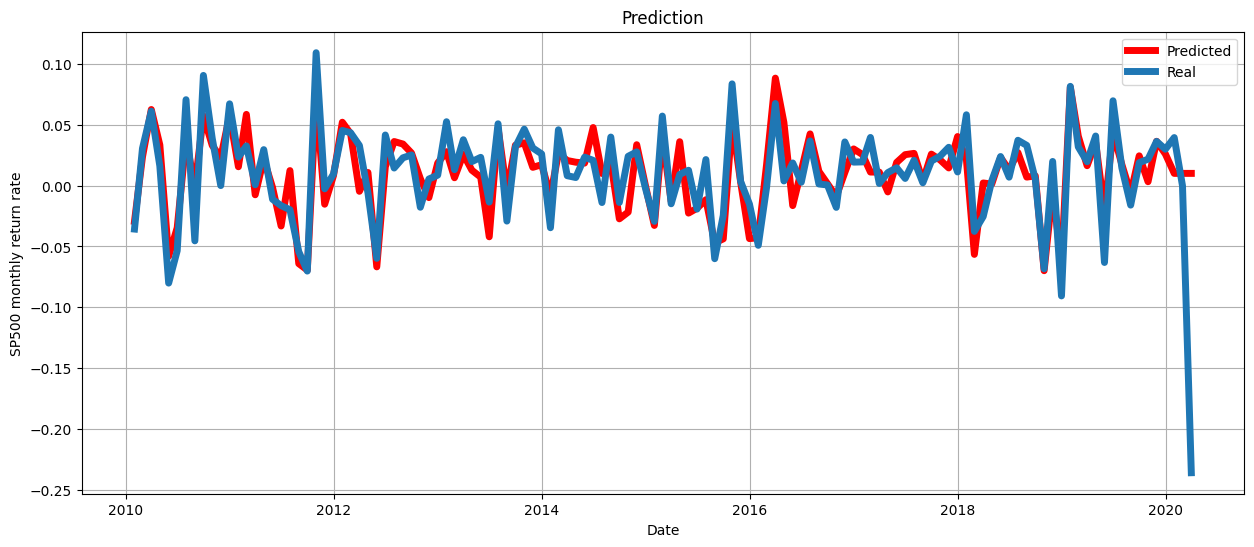

In [67]:

plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data_test['dates'], y_pred_ge, color = 'red', lw = 5)
line_true, = plt.plot(data_test['dates'], y_TEST, lw = 5)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])

## Let's see if with our model we could have made some money

In [68]:
tot = 1

In [70]:
for i in y_TEST:
    return_per_month = tot*i
    tot = tot + return_per_month
tot

9.008049615675468

## So we would have obtained a $900\%$ gain for every euro invested!

#### Probably there is a feature(S&P 500, S&P 500 PE Ratio) that helps too much the algorithms